RNN Network for Linear Sine Regression
======================================

Let us again add "context" to the network, this time by way of RNNs instead of using feed-forward "chunks."

In [2]:
# do imports
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(3301)
import scipy.signal as sig
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Using TensorFlow backend.


In [3]:
def do_lookback(data, steps=1, validation=False):
    temp = np.zeros((data.shape[0] - steps, steps + 1, data.shape[1]))
    temp[:, 0, :] = data[steps:, :]
    for i in range(temp.shape[0]):
        temp[i, 1:] = data[i:i + steps][::-1]

    if validation:
        temp = temp.reshape((temp.shape[0], temp.shape[1]))

    for i in range(temp.shape[0]):
        temp[i, :] = temp[i, :][::-1]

    return temp

In [4]:
# let's define the signals
dur = 128
sample_rate = 128
true_freq = 13.4
noise_freq = 5.8
noise_phase = np.pi/4
noise_amp = 0.25
t = np.linspace(0, dur, dur*sample_rate)
s = np.sin(2*np.pi*true_freq * t)
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)
d = s + noise_amp * np.sin(2*np.pi*noise_freq*t)  # phase shifted input

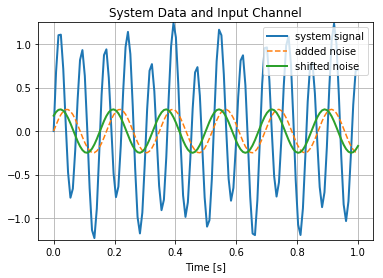

In [5]:
# let's see this phase shift
time = np.linspace(0, 1, sample_rate)
plt.plot(time, d[:sample_rate], label='system signal', lw=2.0)
plt.plot(time, noise_amp * np.sin(2*np.pi*noise_freq*t)[:sample_rate], label='added noise', ls='--')
plt.plot(time, n[:sample_rate], label='shifted noise', lw=2.0)
plt.title('System Data and Input Channel')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim([-1.25, 1.25])
plt.show()
plt.close()

Hopefully you can identify that there is a $45^{\circ}$ phase shift between the noise that is actually in the system and the noise source which we are provided with

In [6]:
# apply lookback 
lb = 16  # NOTE: This is a lot
tar_lb = d[lb:]
wit_lb = do_lookback(n.reshape(n.size, 1), lb)

# reshape for training and testing (samples, lookback, features)
tt = 8  # test time in seconds
tfrac = 8*sample_rate
x_train = wit_lb[:-tfrac, :, :]
y_train = tar_lb[:-tfrac]

x_test = wit_lb[-tfrac:, :, :]
y_test = tar_lb[-tfrac:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((15088, 17, 1), (15088,), (1280, 17, 1), (1280,))


We now have 512 samples, each 1 second long. Like before, we will train on the first 504s and test on the last 8. We can now make the training and testing data

In [7]:
# We can now run our first LSTM recurrent neural network!
model = Sequential()
model.add(SimpleRNN(4, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
# model.add(Dense(4, activation='elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test), batch_size=1000)

W0108 14:44:21.588960 139629127620416 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0108 14:44:28.365664 139629127620416 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0108 14:44:39.891310 139629127620416 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0108 14:44:41.758111 139629127620416 deprecation_wrapper.py:119] From /home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.comp

Train on 15088 samples, validate on 1280 samples
Epoch 1/40
15088/15088 [==============================] - 23s 2ms/step - loss: 0.5325 - val_loss: 0.5198
Epoch 2/40
11000/15088 [====================>.........] - ETA: 0s - loss: 0.5133

/home/rich.ormiston/deepclean_ve/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.768461). Check your callbacks.
  % delta_t_median)


15088/15088 [==============================] - 0s 6us/step - loss: 0.5129 - val_loss: 0.5057
Epoch 3/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5028 - val_loss: 0.5004
Epoch 4/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5006 - val_loss: 0.5002
Epoch 5/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5004 - val_loss: 0.5001
Epoch 6/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5002 - val_loss: 0.5001
Epoch 7/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5001 - val_loss: 0.5001
Epoch 8/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5001 - val_loss: 0.5001
Epoch 9/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5003 - val_loss: 0.5001
Epoch 10/40
15088/15088 [==============================] - 0s 6us/step - loss: 0.5003 - val_loss: 0.5001
Epoch 11/40
15088/15088 [==============================] - 0s 6us/step - l

We can now design our network. Keep in mind, the final output is not a scalar, but rather a vector with dimension equal to the sample rate, i.e, a 1 second prediction. Therefore the final layer of our network must be of this same size.

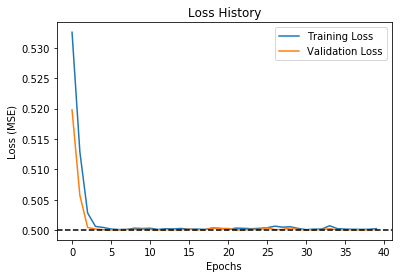

In [8]:
# let's log the loss functions and plot them 
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(0.5, ls='--', color='black')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()
plt.close()

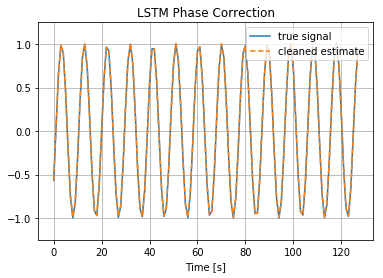

ValueError: operands could not be broadcast together with shapes (1280,) (1024,) 

In [9]:
# make predictions and plots
y_hat = model.predict(x_test)
y_hat = y_hat.flatten()
clean = y_test - y_hat

plt.plot(s[-sample_rate:], label='true signal')
plt.plot(clean[-sample_rate:], label='cleaned estimate', ls='--')
plt.title('LSTM Phase Correction')
plt.xlabel('Time [s]')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim([-1.25, 1.25])
plt.show()
plt.close()

noise_floor = 0.01 * np.random.rand(sample_rate*8)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-sample_rate*8:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-sample_rate*8:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal')
plt.semilogy(freq, signal_psd, label='True Signal')
plt.semilogy(freq, clean_psd, label='True Signal Estimate')
plt.axvline(noise_freq, label='$f_n={}$ Hz'.format(noise_freq), ls='--', color='black', alpha=0.5)
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

Evidently we have been able to nearly perfectly determine the phase since only when we have no mismatch in the phases can we actually achieve meaningful subtraction. Therefore the context provided by the RNN was the necessary ingredient in order that we can understand the temporal structure of our data.

This may seem like overkill and for a simple sine wave, I would agree. But be aware of how stochastic data can apparently become. Finding the (potentially nonlinear) correlation between multiple channels which may be very long would rapidly become intractable by hand.